# Test sample_quality.py functions

In [31]:
from scipy.stats import multivariate_normal as mvn
import numpy as np
import matplotlib.pyplot as plt

import sample_quality as sq
import functions as fn

import importlib
importlib.reload(sq)
# https://www.geeksforgeeks.org/reloading-modules-python/

<module 'sample_quality' from 'C:\\Users\\HechuanWang\\Documents\\GitHub\\MClib\\MCLibPy\\sample_quality.py'>

## Measures

### ESS

$$ESS = \sum_{m}\frac{1}{{w^{(m)}}^2}$$
ESS is between 1 and N. We can devide it by N to normalize ESS over sample size

$$\frac{ESS}{N} = \frac{1}{N} \sum_{m}\frac{1}{{w^{(m)}}^2}$$

### chi-square like measure
$$\begin{array}{l}
D_{\chi^2 } =\int \frac{\pi^{\prime } {\left(x\right)}^2 }{\pi \left(x\right)}\;\mathit{dx}-1\\
=\int \frac{\sum_m {\left\lbrack w^{\left(m\right)} \delta \left(x-x^{\left(m\right)} \right)\right\rbrack }^2 }{\pi \left(x\right)}\;\mathit{dx}-1
\end{array}$$
because
$$\frac{\sum_m {\left\lbrack w^{\left(m\right)} \delta \left(x-x^{\left(m\right)} \right)\right\rbrack }^2 }{\pi \left(x\right)}=\left\lbrace \begin{array}{cc}
0 & x\not= x^{\left(m\right)} \\
\frac{{w^{\left(m\right)} }^2 {\delta \left(0\right)}^2 }{\pi \left(x^{\left(m\right)} \right)} & x=x^{\left(m\right)} 
\end{array}\right.$$
Therefore
$$D_{\chi^2 } =\sum_m \frac{{w^{\left(m\right)} }^2 {\delta \left(0\right)}^2 }{\pi \left(x^{\left(m\right)} \right)}-1$$
TO remove the infinity
$$\tilde{D} =\frac{D_{\chi^2 } +1}{{\delta \left(0\right)}^2 }=\sum_m \frac{{w^{\left(m\right)} }^2 }{\pi \left(x^{\left(m\right)} \right)}$$

## vs shift

p vs Dchi, samples from N(0,I) by frequency p, all dimensions of samples from U(-3,3) other-wise


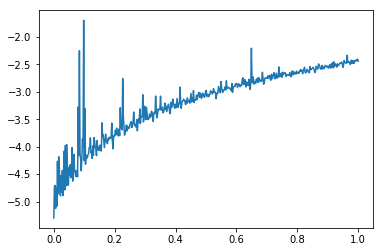

tau vs Dchi, samples from N(tau,I)


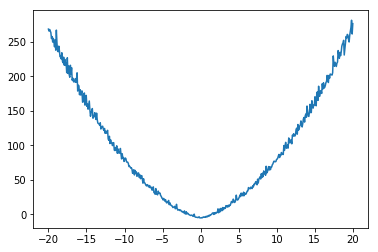

tau vs Dchi, samples from N(0,tau*I)


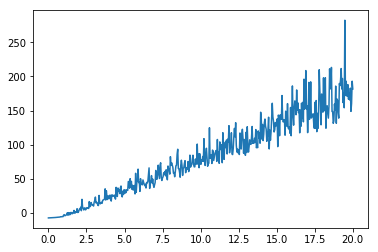

In [10]:
# globals
D = 2
N = 10000

# define target function
pi = lambda x: mvn.pdf(x, mean=0*np.ones(shape=D),cov=np.eye(D))
piMM = lambda x: np.prod(0.5*(np.cos(x)+1),axis=1)

# define sampling process
def sampleshift(tau):
    mu = 0 * np.ones(shape=D)
    mu[0] = tau
    x = mvn.rvs(mean=mu, cov=np.eye(D),size=N)
    return x
def samplescale(tau):
    mu = 0 * np.ones(shape=D)
    x = mvn.rvs(mean=mu, cov=tau*np.eye(D),size=N)
    return x
def sampleMM(M):
    xout = np.ones([0,D])
    for m in range(1,M+1):
        mu = 2*np.pi*m * np.ones(shape=D)
        x = mvn.rvs(mean=mu, cov=np.eye(D),size=N)
        xout = np.vstack((x,xout))
    Ntemp = np.size(xout,0)
    ind = np.random.choice(a=np.arange(Ntemp),p=np.ones(Ntemp)/Ntemp,size=N)
    xout = xout[ind,:]
    return xout
def sampleshape(tau):
    N2 = int(tau*N)
    N1 = N - N2
    mu = 0 * np.ones(shape=D)
    x1 = mvn.rvs(mean=mu, cov=np.eye(D),size=N1)
    x2 = np.random.uniform(low=-3.0, high=3.0, size=(N2,D))
    xout = np.vstack((x1,x2))
    return xout

def samplesize(N):
    mu = 0 * np.ones(shape=D)
    x = mvn.rvs(mean=mu, cov=np.eye(D),size=N)
    return x

# define containers
def plot(sample, measure, pi, tau):
    KLD_log = []
    for i in range(len(tau)):
        x = sample(tau[i])
        KLD_log.append(np.log(measure(x, pi)))
    plt.figure()
    plt.plot(tau, KLD_log)
    plt.show()
    return

print('p vs Dchi, samples from N(0,I) by frequency p, all dimensions of samples from U(-3,3) other-wise')
tau = np.linspace(0.0,1.0,500)
plot(sampleshape, sq.Dchi2, pi, tau)

print('tau vs Dchi, samples from N(tau,I)')
tau = np.linspace(-20.0,20.0,500)
plot(sampleshift, sq.Dchi2, pi, tau)

print('tau vs Dchi, samples from N(0,tau*I)')
tau = np.linspace(0.0001,20.0,500)
plot(samplescale, sq.Dchi2, pi, tau)


The unimodal distribution test shows the measure is sensitive to shape, shift, and scaling of the distribution.

N vs Dchi, samples from N(2*pi*N,I), target is prod(cos(x))


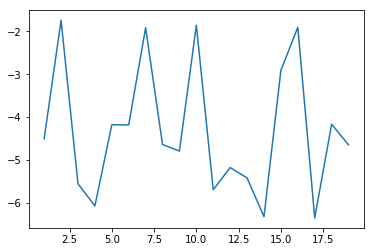

repeat the process


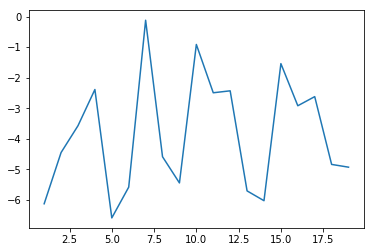

In [11]:
print('N vs Dchi, samples from N(2*pi*N,I), target is prod(cos(x))')
n = np.arange(1,20)
plot(sampleMM, sq.Dchi2, piMM, n)

print('repeat the process')
n = np.arange(1,20)
plot(sampleMM, sq.Dchi2, piMM, n)

This step, I created a multi-modal unnormalized target:

$$\pi\left(\mathit{\mathbf{x}}\right)=\prod_{d\in D} 0\ldotp 5\left(\mathrm{cos}\left(x_d \right)+1\right)$$

Horizonal axis N means sample from how many distributions. looks like it is not sensitive to how many modes are sampled.

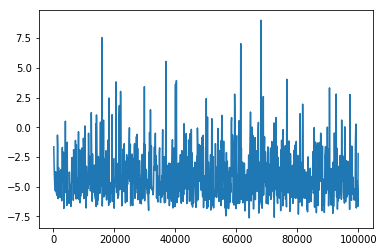

In [12]:
N = np.arange(1,1000)*100
plot(samplesize, sq.Dchi2, piMM, N)

The result shows that the measure is also not very informative.

In [17]:
log = []
for i in range(10000):
    x = samplesize(10000)
    log.append(np.log(sq.Dchi2(x, pi)))

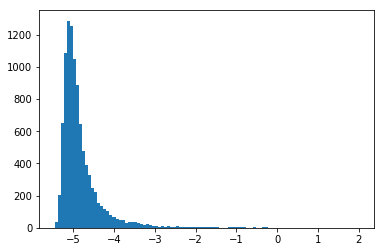

In [18]:
plt.figure()
plt.hist(log,100)
plt.show()

the measure is done on the same target N(0,I) and 10000 group of samples from the true distribution, each group 10000 samples. This show the histogram of measure of all groups.

In [19]:
log = []
for i in range(10000):
    x = samplesize(1000)
    log.append(np.log(sq.Dchi2(x, pi)))

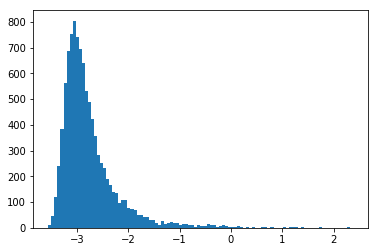

In [20]:
plt.figure()
plt.hist(log,100)
plt.show()

the measure is done on the same target N(0,I) and 10000 group of samples from the true distribution, each group 10000 samples. This show the histogram of measure of all groups.

It shows the measure is higher comparing to 10000 samples.

In [21]:
log = []
for i in range(10000):
    x = samplesize(100)
    log.append(np.log(sq.Dchi2(x, pi)))

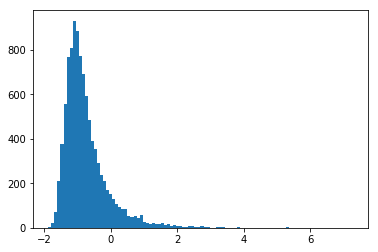

In [22]:
plt.figure()
plt.hist(log,100)
plt.show()

100 samples, even higher.

With one modification, the measure is much less sensitive to the size of the samples.

$$\tilde{D}_N =M\sum_m \frac{{w^{\left(m\right)} }^2 }{\pi \left(x^{\left(m\right)} \right)}$$

In [37]:
def Dchi2NvsM(M):
    log = []
    for i in range(1000):
        x = samplesize(100)
        log.append(np.log(sq.Dchi2N(x, pi)))
    return np.mean(log), np.std(log)

mu = []
std = []

N = np.arange(1,100)*100

for i in range(len(N)):
    mu_c, std_c = Dchi2NvsM(N[i])
    mu.append(mu_c)
    std.append(std_c)

average log (DN) vs sample size


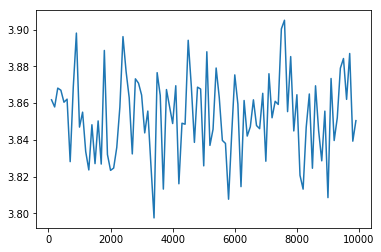

std of log (DN) vs sample size


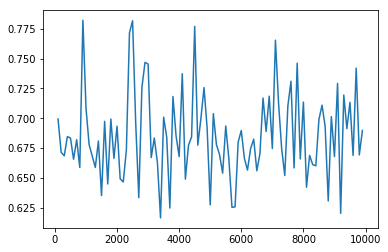

In [38]:
print('average log (DN) vs sample size')
plt.figure()
plt.plot(N,mu)
plt.show()
print('std of log (DN) vs sample size')
plt.figure()
plt.plot(N,std)
plt.show()